# README for 01_simple_example

This example shows how to use optzer program for optimizing two parameters (a,b) of a simple line function, $f(x) =a x +b$. 

The simple_func.py program computes the line function with a and b parameters read from a file, in.params.simple.

The referece data (of 100 points) was generated from $g(x) = ax + b + \varepsilon$ where $\varepsilon = \mathcal{N}(0,\sigma^2)$ is the Gaussian noise added to the line function. And the parameters of the reference data are $a = 1.0$ and $b = 0.0$.

Necessary files for performing optzer program:
- `in.optzer` --- input for optzer
- `in.vars.optzer` --- initial guess of parameters and (soft and hard) limit of parameter space
- `subjob.sh` --- subjob script to be performed by each individual
- `in.params.simple` --- contents of this file to be replaced during the optimization and used by simple_func.py
- `data.ref.simple` --- reference data


In [1]:
!ls

00_test          in.optzer        makefile         subjob.sh
README.ipynb     in.params.simple out.optzer.REF   test.py
data.ref.simple  in.vars.optzer   simple_func.py


In [1]:
# Even if there are many junk files, `make init` removes unnecessary files and retore it to the initial state
!make init
!ls

rm -f in.vars.optzer.[1-9]* *~
rm -rf out.cs.* subdir_*
rm -rf db.optzer.json out.optzer in.vars.optzer.best
00_test          data.ref.simple  makefile         subjob.sh
README.ipynb     in.optzer        out.csv          test.py
__pycache__      in.params.simple out.optzer.REF
best_data        in.vars.optzer   simple_func.py


In [2]:
!cat in.optzer

num_iteration       50

print_level         1

target        simple
param_files   in.params.simple

opt_method        cs
# opt_method      wpe
# tpe_nsmpl_prior   20
num_individuals   4
cs_fraction          0.25

update_vrange        10
fval_upper_limit     100.0


Above `in.optzer` file sets up configuration as follows:
- `target  simple` --- specifies to use `data.ref.simple` as a reference data and `data.opt.simple` for trial data.
- `param_files  in.params.simple` --- the file used to write trial parameters and used to compute data in a external program with the trial parameters
- `opt_method  cs` --- specifies cuckoo search as an optimization method

In [3]:
!optzer --nproc 5 --random-seed 42 2>&1 | tee out.optzer


 optzer --- optimize parameters of any external program to any target property ---

   Executed as /Users/kobayashi/.anyenv/envs/pyenv/versions/nap/bin/optzer --nproc 5 --random-seed 42
            at /Users/kobayashi/src/optzer/examples/01_simple_example on mbp-rk4
            at 2022-12-29 01:21:13

   Please cite:
     1) R. Kobayashi, J. Open Source Software, 6(57), 2768 (2021)

 Random seed was given: 42

 Input
 ----------
   num of processes (given by --nproc option)   5
   param_files    in.params.simple
   opt_method  cs
   num_individuals   4
   fraction           0.2500
   num_iteration   50
   missing_value   1.0
 ----------

 Initial variable ranges
               a:  -10.000   10.000
               b:  -10.000   10.000

 Reference data and weights:
           simple  1.000

 # iid,losses=      iid     simple      total
   iid,losses=        1    13.3795    13.37946
   iid,losses=        2   100.0000   100.00000
   iid,losses=        4   100.0000   100.00000
   iid,losses

In [5]:
# To use the following functions in optzer package, add python path
import sys
sys.path.append('../../')

In [5]:
from optzer.io import read_data, read_vars_optzer
refd = read_data('data.ref.simple')

In [7]:
# Optimized parameters are stored in in.vars.optzer.best file
vnames, vs, _, _, _ = read_vars_optzer('in.vars.optzer.best')
vs

{'a': 1.0270409, 'b': -0.0103991}

In [9]:
# Use line function in the simple_func.py script
from simple_func import line

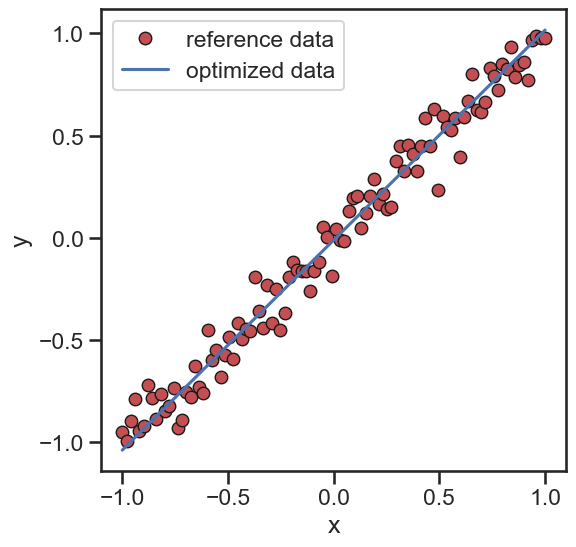

In [11]:
# Let's plot the reference data and line with optimized parameters
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# The same x points used in the simple_func.py
xs = np.linspace(-1.0,1.0,100)

# Compute y points with line function and optimized parameters a and b
yopt = line(xs,vs['a'],vs['b'])

sns.set(context='talk',style='ticks')
plt.figure(figsize=(6,6))
plt.plot(xs,refd['data'],'ro',mec='k',label='reference data')
plt.plot(xs,yopt,'b-',label='optimized data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

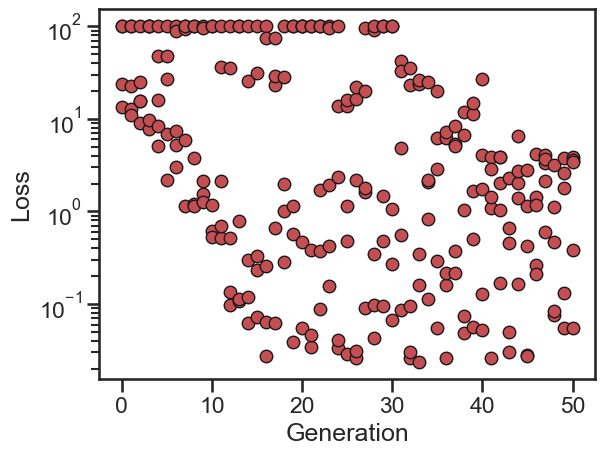

In [12]:
import pandas as pd
db = pd.read_json('db.optzer.json')
gens = db.gen
iids = db.iid
losses = db.loss

plt.plot(gens,losses,'ro',mec='k')
plt.yscale('log')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()


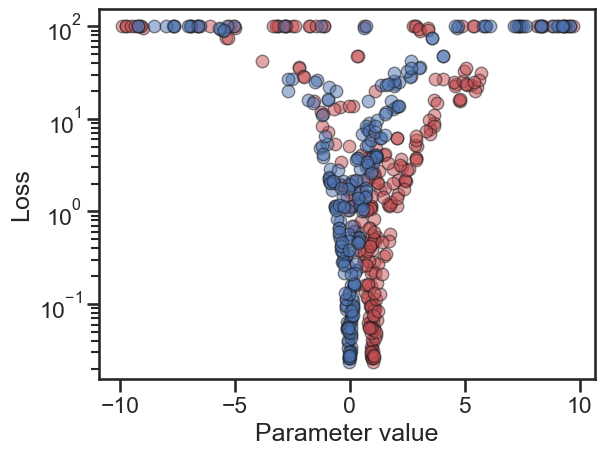

In [14]:
ms = {'a':'ro', 'b':'bo'}
for k in vnames:
    prms = db[k]
    plt.plot(prms,losses, ms[k], mec='k', label=k, alpha=.5)
plt.yscale('log')
plt.xlabel('Parameter value')
plt.ylabel('Loss')
plt.show()


Above plot shows that, as the loss goes down, the parameters a and b converge to the optimal values 1.0 and 0.0, respectively.